# Восстановление золота из руды

# Описание задачи

Имеются данные с параметрами добычи и очистки руды. Необходимо построить модель машинного обучения, которая предскажет коэффициент восстановления золота из золотосодержащей руды.

# План работы

1. Подготовка данных
    1. Загрузка и изучение данных
    2. Проверка правильности расчёта эффективности обогащения
    3. Анализ признаков, недоступных в тестовой выборке
    4. Предобработка данных
2. Анализ данных
    1. Концентрация металлов на различных этапах очистки
    2. Распределение размеров гранул сырья
    3. Суммарная концентрация всех веществ на разных стадиях
3. Модель
    1. Функция для вычисления итоговой sMAPE
    2. Кросс-валидация
        1. Модель линейной регрессии
        2. Модель решающего дерева в регрессии
        3. Модель случайного леса в регрессии
    3. Оценка константной модели
    4. Проверка лучшей модели на тестовой выборке

# Описание данных

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * Xanthate — ксантогенат (промотер, или активатор флотации);
    * Sulphate — сульфат (на данном производстве сульфид натрия);
    * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

## Подготовка данных

### Загрузка и изучение данных

In [227]:
#Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [228]:
#Загрузка таблиц
data_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('datasets/gold_recovery_full_new.csv')

In [229]:
#Просмотр обучающих данных, первые 5 строк
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [230]:
#Просмотр сводной информации об обучающих данных
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [231]:
#Поиск пропусков в обучающих данных
pd.set_option('display.max_rows', None)
data_train.isna().sum()

date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     0
final.output.tail_pb                                   100
final.output.tail_sol                                    5
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           20
primary_cleaner.input.depressant                        32
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                   86
primary_cleaner.output.concentrate_sol                 2

In [232]:
#Просмотр тестовых данных, первые 5 строк
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


Вывод. Тестовые данные состоят из 53 столбцов. Это меньше, чем у обучающих данных (87 столбцов).

In [233]:
#Просмотр сводной информации о тестовых данных
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [234]:
#Поиск пропусков в тестовых данных
data_test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [235]:
#Просмотр исходных данных, первые 5 строк
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Вывод. Исходные данные, как и обучающие, состоят из 87 столбцов.

In [236]:
#Просмотр сводной информации об исходных данных
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Вывод. Исходные данные имеют 19438 объектов, что равно сумме объектов обучающих и тестовых данных.

In [237]:
#Поиск пропусков в таблице исходных данных
data_full.isna().sum()

date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     1
final.output.tail_pb                                   101
final.output.tail_sol                                    6
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           24
primary_cleaner.input.depressant                        37
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         104
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.output.concentrate_sol                 3

### Проверка правильности расчёта эффективности обогащения

In [238]:
#С-концентрация Au после флотации, F-концентрация Au в сырье, T-концентрация Au в отвальных хвостах после флотации
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']
data_train_recovery_calc = C * (F - T) / (F * (C - T)) * 100
data_train_recovery = data_train['rougher.output.recovery']

In [239]:
#Средняя абсолютная ошибка
mean_absolute_error(data_train_recovery, data_train_recovery_calc)

9.73512347450521e-15

Выводы. Поскольку средняя абсолютная ошибка близка к нулю, эффективность обогащения рассчитана правильно.

### Анализ признаков, недоступных в тестовой выборке

In [240]:
#Размер таблицы обучающих данных
data_train.shape

(14149, 87)

In [241]:
#Размер таблицы тестовых данных
data_test.shape

(5290, 53)

Вывод. У таблиц разница в 34 столбца.

In [242]:
#Вывод столбцов отсутствующих в таблице тестовых данных
for value in data_train.columns:
    if value not in data_test.columns:
        print(value)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

Вывод. Рассматривая названия перечисленных признаков с использованием шаблона [этап].[тип параметра].[название параметра], можно сказать, что все эти признаки имеют тип параметра output или calculation, то есть относятся к параметрам продукта или являются расчетными характеристиками. Очевидно, что тест должен проводится только на параметрах сырья, без параметров продукта и расчетных характеристик.

### Предобработка данных

In [243]:
#Заполнение пропусков в обучающих данных
data_train.ffill(inplace=True)

In [244]:
#Заполнение пропусков в исходных данных
data_full.ffill(inplace=True)

In [245]:
#Заполнение пропусков в тестовых данных
data_test.ffill(inplace=True)

## Анализ данных

### Концентрация металлов на различных этапах очистки

In [246]:
#Функция для построения графика изменения концентрации Ag, Au, Pb на различных этапах очистки
def graph():
    s=pd.Series([rougher_in_mean,rougher_out_mean,primary_cleaner_mean,final_mean],index=x_values)
    ax=s.plot(title='metall concentration', style='o-')
    ax.legend(['Ag','Au','Pb'])
    plt.xlabel('Этапы очистки')
    plt.ylabel('Концентрация')

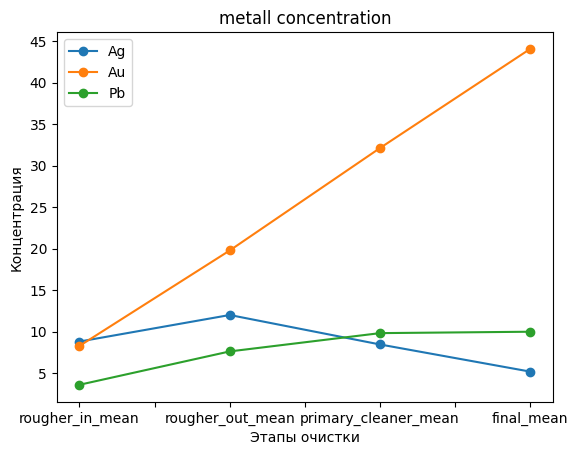

In [247]:
#Названия этапов очистки для построения графика
x_values = ['rougher_in_mean','rougher_out_mean','primary_cleaner_mean','final_mean']

#Вычисление средних значений концентрации Ag на различных этапах очистки
rougher_in_mean = data_full['rougher.input.feed_ag'].mean()
rougher_out_mean = data_full['rougher.output.concentrate_ag'].mean()
primary_cleaner_mean = data_full['primary_cleaner.output.concentrate_ag'].mean()

final_mean = data_full['final.output.concentrate_ag'].mean()

#Построение графика на основе полученных средних
graph()

#Вычисление средних значений концентрации Au на различных этапах очистки
rougher_in_mean = data_full['rougher.input.feed_au'].mean()
rougher_out_mean = data_full['rougher.output.concentrate_au'].mean()
primary_cleaner_mean = data_full['primary_cleaner.output.concentrate_au'].mean()
final_mean = data_full['final.output.concentrate_au'].mean()

#Построение графика на основе полученных средних
graph()

#Вычисление средних значений концентрации Pb на различных этапах очистки
rougher_in_mean = data_full['rougher.input.feed_pb'].mean()
rougher_out_mean = data_full['rougher.output.concentrate_pb'].mean()
primary_cleaner_mean = data_full['primary_cleaner.output.concentrate_pb'].mean()
final_mean = data_full['final.output.concentrate_pb'].mean()

#Построение графика на основе полученных средних
graph()

Выводы. Концентрация Au растет существенно, концентрация Pb растет несущественно, а концентрация Ag, после незначительного роста вначале, падает.

### Распределение размеров гранул сырья 

Размеры гранул сырья представлены в столбце 'rougher.input.feed_size'

Text(0, 0.5, 'Частота значений размера гранул')

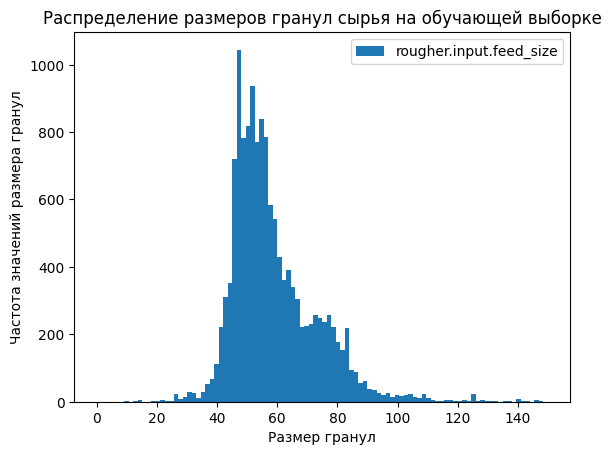

In [248]:
#Построение гистограммы распределения размеров гранул сырья на обучающей выборке
data_train.plot(kind='hist', y='rougher.input.feed_size', range = (0, 150), bins=100)
plt.title('Распределение размеров гранул сырья на обучающей выборке')
plt.xlabel('Размер гранул')
plt.ylabel('Частота значений размера гранул')

Text(0, 0.5, 'Частота значений размера гранул')

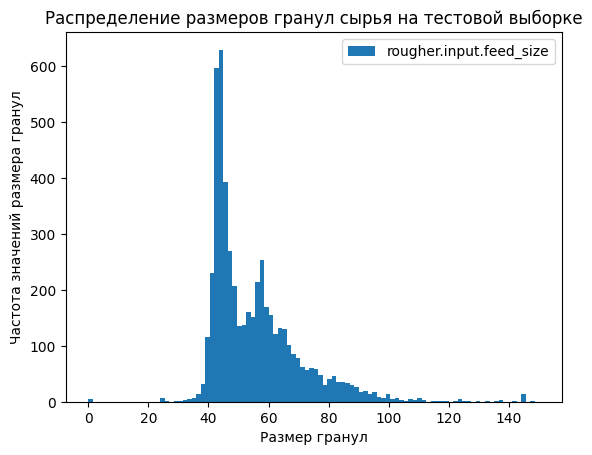

In [249]:
#Построение гистограммы распределения размеров гранул сырья по тестовой выборке
data_test.plot(kind='hist', y='rougher.input.feed_size', range = (0, 150), bins=100)
plt.title('Распределение размеров гранул сырья на тестовой выборке')
plt.xlabel('Размер гранул')
plt.ylabel('Частота значений размера гранул')

In [250]:
#Выделение признака с размерами гранул сырья из обучающей и тестовой выборки для дальнейшего сравнения распределений
x=data_train['rougher.input.feed_size']
y=data_test['rougher.input.feed_size']

Text(0, 0.5, 'Частота значений размера гранул')

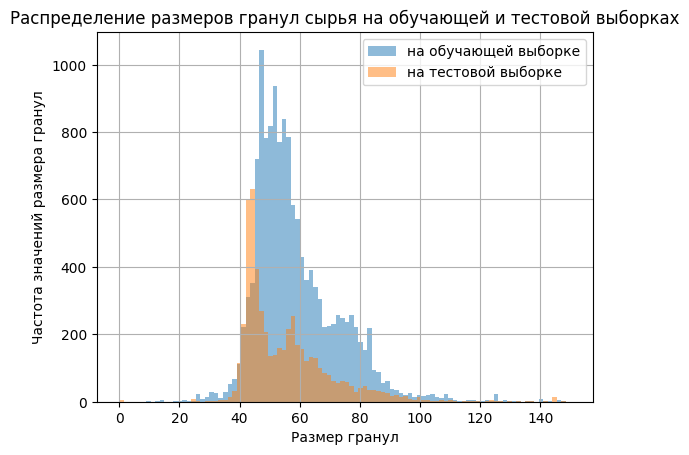

In [251]:
#Сравнение распределений размера гранул сырья в обучающей и тестовой выборках
x.hist(alpha=0.5,label='x',range = (0, 150), bins=100)
y.hist(alpha=0.5,label='y',range = (0, 150), bins=100)
plt.legend(['на обучающей выборке', 'на тестовой выборке'])
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках')
plt.xlabel('Размер гранул')
plt.ylabel('Частота значений размера гранул')

### Суммарная концентрация всех веществ на разных стадиях

In [252]:
#Четыре выборки на основе исходных данных для четырех стадий
data_rougher_input = data_full[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
                              'rougher.input.feed_au']]

data_rougher_output = data_full[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
                                'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']]

data_primary_cleaner = data_full[['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
                                 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au']]

data_final = data_full[['final.output.concentrate_ag', 'final.output.concentrate_pb',
                       'final.output.concentrate_sol', 'final.output.concentrate_au']]

In [253]:
#Сумма концентрации всех веществ на каждой из четырех стадий
data_rougher_input_sum = data_rougher_input.sum(axis=1)

data_rougher_output_sum = data_rougher_output.sum(axis=1)

data_primary_cleaner_sum = data_primary_cleaner.sum(axis=1)

data_final_sum = data_final.sum(axis=1)

Text(0, 0.5, 'Частота значений концентрации')

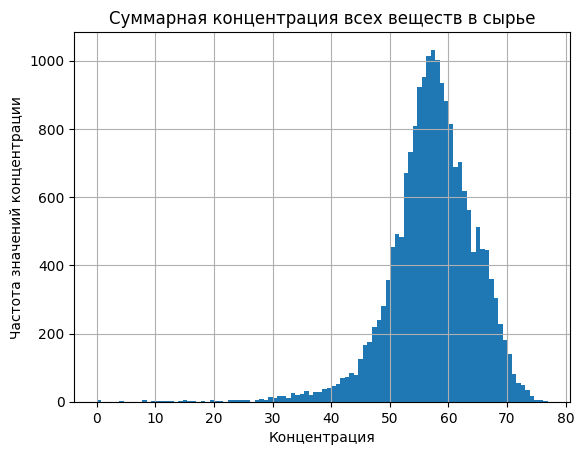

In [254]:
#Распределение суммарной концентрации всех веществ в сырье
data_rougher_input_sum.plot(kind='hist', bins=100, grid=True, title='Суммарная концентрация всех веществ в сырье')
plt.xlabel('Концентрация')
plt.ylabel('Частота значений концентрации')

Text(0, 0.5, 'Частота значений концентрации')

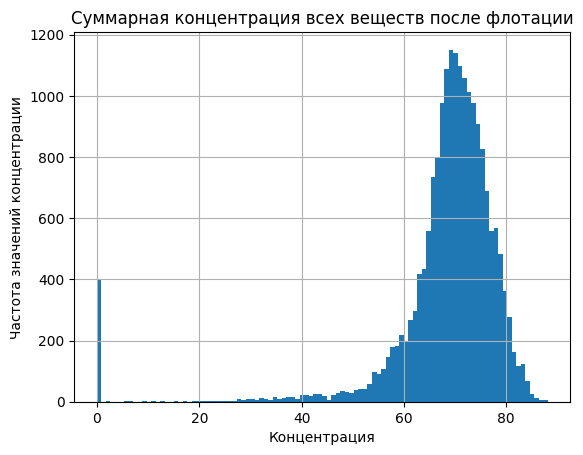

In [255]:
#Распределение суммарной концентрации всех веществ после флотации
data_rougher_output_sum.plot(kind='hist', bins=100, grid=True, title='Суммарная концентрация всех веществ после флотации')
plt.xlabel('Концентрация')
plt.ylabel('Частота значений концентрации')

Вывод. Заметно значительное количество аномальных значений равных 0. Удалим их из распределения.

In [256]:
#Удаление аномальных значений на предыдущем распределении
data_rougher_output_sum = data_rougher_output_sum[data_rougher_output_sum>0]

Text(0, 0.5, 'Частота значений концентрации')

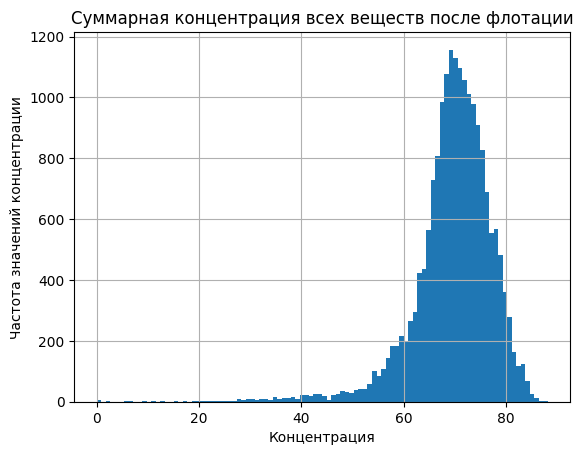

In [257]:
#Распределение суммарной концентрации всех веществ после флотации без аномальных значений
data_rougher_output_sum.plot(kind='hist', bins=100, grid=True, title='Суммарная концентрация всех веществ после флотации')
plt.xlabel('Концентрация')
plt.ylabel('Частота значений концентрации')

Text(0, 0.5, 'Частота значений концентрации')

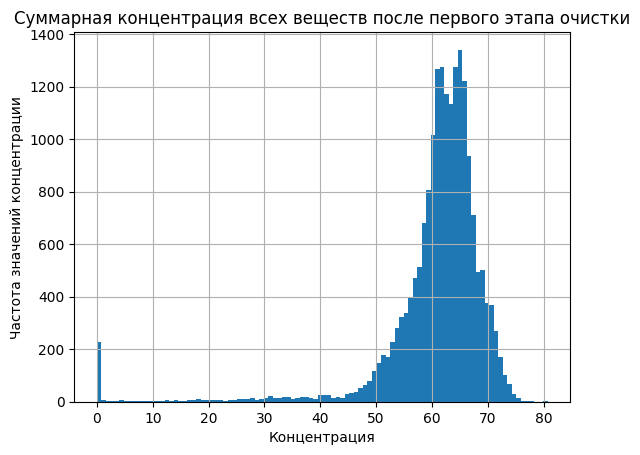

In [258]:
#Распределение суммарной концентрации всех веществ после первого этапа очистки
data_primary_cleaner_sum.plot(kind='hist', bins=100, grid=True, title='Суммарная концентрация всех веществ после первого этапа очистки')
plt.xlabel('Концентрация')
plt.ylabel('Частота значений концентрации')

Вывод. Заметны аномальные значения вблизи 0. Удалим их из распределения.

In [259]:
#Удаление аномальных значений из предыдущего распределения.
data_primary_cleaner_sum = data_primary_cleaner_sum[data_primary_cleaner_sum>1]

Text(0, 0.5, 'Частота значений концентрации')

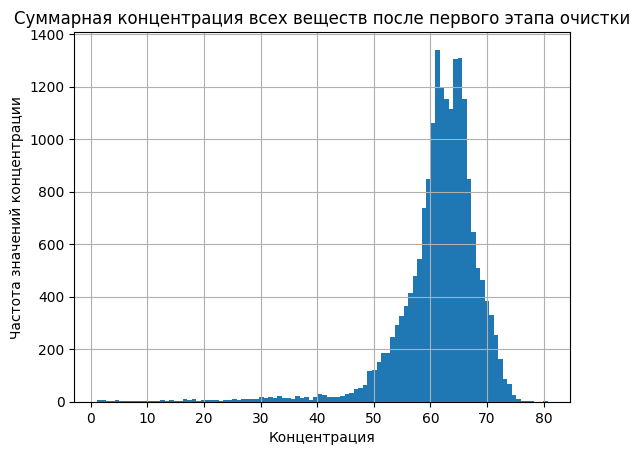

In [260]:
#Распределение суммарной концентрации всех веществ после первого этапа очистки без аномальных значений.
data_primary_cleaner_sum.plot(kind='hist', bins=100, grid=True, title='Суммарная концентрация всех веществ после первого этапа очистки')
plt.xlabel('Концентрация')
plt.ylabel('Частота значений концентрации')

Text(0, 0.5, 'Частота значений концентрации')

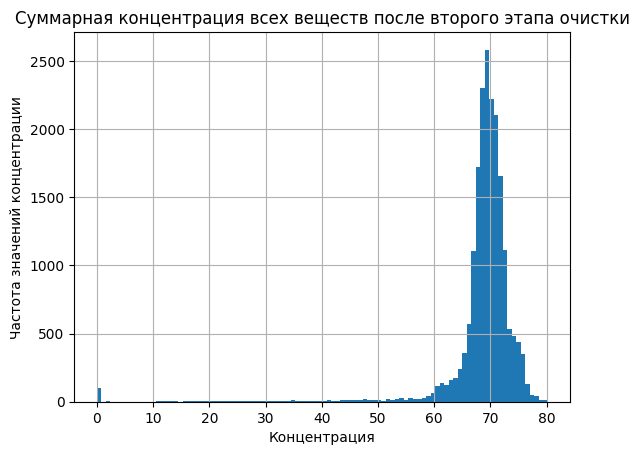

In [261]:
#Распределение суммарной концентрации всех веществ после второго этапа очистки.
data_final_sum.plot(kind='hist', bins=100, grid=True, title='Суммарная концентрация всех веществ после второго этапа очистки')
plt.xlabel('Концентрация')
plt.ylabel('Частота значений концентрации')

Вывод. Заметны аномальные значения вблизи 0. Удалим их из распределения.

In [262]:
#Удаление аномальных значений из предыдущего распределения.
data_final_sum = data_final_sum[data_final_sum>0]

Text(0, 0.5, 'Частота значений концентрации')

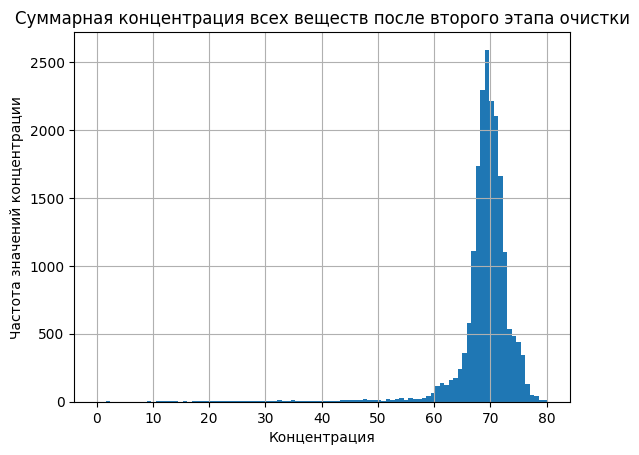

In [263]:
#Распределение суммарной концентрации всех веществ после второго этапа очистки без аномальных значений.
data_final_sum.plot(kind='hist', bins=100, grid=True, title='Суммарная концентрация всех веществ после второго этапа очистки')
plt.xlabel('Концентрация')
plt.ylabel('Частота значений концентрации')

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
<font color='green'><br>
ОК. Ещё пару строк по выбросам: в некоторых проектах - это важно, избавиться от выбросов<br>

И вот если обратиться к нашему проекту:<br>
1) Есть нулевые аномалии в суммарных концентрациях - и их надо "убить". Дело в том, что хоть грамм чего-нибудь но есть в "суммарной руде"- соли+золото+серебро+свинец - точно что-то должно быть.. А если мы имеем ноль, значит большая вероятность неточности измерений.<br>
    
2)А вот с выбросами как в приниципе..<br>
Тут на обсуждение: наша цель - предсказывать модель на реальных данных. И вот эти выбросы - это и есть реальная концентрация. И нам важно, чтобы модель умела и их тоже видеть и обрабатывать. Если их убрать из модели, то получится, что у нас она станет как бы искусственной. Т.е. будет работать только в небольших диапазонах - потому что обучалась только в них.<br>
    
Поэтому, тут так: выбросы - это не всегда то, от чего надо избавляться))) Ещё зависит от бизнес-задачи.<br>
    
Кстати<br>
если говорить о теории выбросов с помощью графика "ящик с усами", то вот это интервал q3+-1.5*iqr говорит действильно о них самых<br>
Но нет рекоммендаций к их удалению. Говорят так "на усмотрение бизнеса".<br>
А вот если взять вот этот интервал q3+3*iqr:  то тут уж с очень высокой вероятность можно говорить о грубых выбросах.

## Модель

### Функция для вычисления итоговой sMAPE

In [264]:
#Функция для вычисления итоговой sMAPE
def smape(target_rougher, predict_rougher, target_final, predict_final):
    
    differevce_target_predict_rougher = abs(target_rougher - predict_rougher)
    summa_target_predict_rougher = abs(target_rougher) + abs(predict_rougher)
    smape__rougher = ((differevce_target_predict_rougher / (summa_target_predict_rougher / 2)).sum() * 100) / len(target_rougher)
    
    differevce_target_predict_final = abs(target_final - predict_final)
    summa_target_predict_final = abs(target_final) + abs(predict_final)
    smape__final = ((differevce_target_predict_final / (summa_target_predict_final / 2)).sum() * 100) / len(target_final)
    
    return ((1/4) * smape__rougher + (3/4) * smape__final)

### Кросс-валидация

In [265]:
#Для обучения модели используем в качестве обучающую выборку с признаками тестовых данных.
data = data_train[data_test.columns]

In [266]:
#Удалим из обучающей выборки бесполезный для обчения признак даты.
data = data.drop(['date'], axis=1)

In [267]:
#Сохраним признаки для обучения модели в переменную features
features = data

In [268]:
#Извлечем целевые признаки из исходных данных у тех объектов, которые присутствуют в выборке data_train
target_1 = data_full[data_full['date'].isin(data_train['date'])]['rougher.output.recovery'].reset_index(drop
= True)
target_2 = data_full[data_full['date'].isin(data_train['date'])]['final.output.recovery'].reset_index(drop
= True)

#### Модель линейной регрессии

In [269]:
#Пустой список для оценок модели
scores = []

In [270]:
#Размер каждого блока данных в кросс-валидации
sample_size = int(len(data)/100)

In [271]:
#Обучение и оценка моделей методом кросс-валидации
for i in range(0, len(data), sample_size):
    valid_indexes = list(data.loc[i:i+sample_size-1].index)
    train_indexes = list(data.loc[:i-1].index) + list(data.loc[i+sample_size:].index)
    features_train = features.query('index in @train_indexes')
    features_valid = features.query('index in @valid_indexes')    
    target_1_train = target_1[train_indexes]
    target_1_valid = target_1[valid_indexes]
    target_2_train = target_2[train_indexes]
    target_2_valid = target_2[valid_indexes]
    lg_model_1 = LinearRegression()
    lg_model_2 = LinearRegression()
    lg_model_1 = lg_model_1.fit(features_train, target_1_train)
    lg_model_2 = lg_model_2.fit(features_train, target_2_train)
    predictions_valid_1 = lg_model_1.predict(features_valid)
    predictions_valid_2 = lg_model_2.predict(features_valid)
    score = smape(target_1_valid, predictions_valid_1, target_2_valid, predictions_valid_2)
    scores.append(score)

In [272]:
#Итоговая оценка модели
final_score = sum(scores) / len(scores)

In [273]:
#Вывод итоговой оценки модели
final_score

10.09327935375315

#### Модель решающего дерева в регрессии

In [274]:
#Пустой список для оценок модели
scores = []

In [275]:
#Размер каждого блока данных в кросс-валидации
sample_size = int(len(data)/100)

In [276]:
#Обучение и оценка моделей методом кросс-валидации
for i in range(0, len(data), sample_size):
    valid_indexes = list(data.loc[i:i+sample_size-1].index)
    train_indexes = list(data.loc[:i-1].index) + list(data.loc[i+sample_size:].index)
    features_train = features.query('index in @train_indexes')
    features_valid = features.query('index in @valid_indexes')    
    target_1_train = target_1[train_indexes]
    target_1_valid = target_1[valid_indexes]
    target_2_train = target_2[train_indexes]
    target_2_valid = target_2[valid_indexes]
    dtr_model_1 = DecisionTreeRegressor(random_state=12345, max_depth=5)
    dtr_model_2 = DecisionTreeRegressor(random_state=12345, max_depth=5)
    dtr_model_1 = dtr_model_1.fit(features_train, target_1_train)
    dtr_model_2 = dtr_model_2.fit(features_train, target_2_train)
    predictions_valid_1 = dtr_model_1.predict(features_valid)
    predictions_valid_2 = dtr_model_2.predict(features_valid)
    score = smape(target_1_valid, predictions_valid_1, target_2_valid, predictions_valid_2)
    scores.append(score)

In [277]:
#Итоговая оценка модели
final_score = sum(scores) / len(scores)

In [278]:
#Вывод итоговой оценки модели
final_score

10.427183605474024

#### Модель случайного леса в регрессии

In [279]:
#Пустой список для оценок модели
scores = []

In [280]:
#Размер каждого блока данных в кросс-валидации
sample_size = int(len(data)/100)

In [281]:
#Обучение и оценка моделей методом кросс-валидации
for i in range(0, len(data), sample_size):
    valid_indexes = list(data.loc[i:i+sample_size-1].index)
    train_indexes = list(data.loc[:i-1].index) + list(data.loc[i+sample_size:].index)
    features_train = features.query('index in @train_indexes')
    features_valid = features.query('index in @valid_indexes')
    target_1_train = target_1[train_indexes]
    target_1_valid = target_1[valid_indexes]
    target_2_train = target_2[train_indexes]
    target_2_valid = target_2[valid_indexes]
    rfr_model_1 = RandomForestRegressor(random_state=12345, n_estimators=8, max_depth=5)
    rfr_model_2 = RandomForestRegressor(random_state=12345, n_estimators=8, max_depth=5)
    rfr_model_1 = rfr_model_1.fit(features_train, target_1_train)
    rfr_model_2 = rfr_model_2.fit(features_train, target_2_train)
    predictions_valid_1 = rfr_model_1.predict(features_valid)
    predictions_valid_2 = rfr_model_2.predict(features_valid)
    score = smape(target_1_valid, predictions_valid_1, target_2_valid, predictions_valid_2)
    scores.append(score)

In [282]:
#Итоговая оценка модели
final_score = sum(scores) / len(scores)

In [283]:
#Вывод итоговой оценки модели
final_score

9.723457029725257

**Вывод.** Судя по итоговым оценкам, лучшей моделью оказалась модель случайного леса в регрессии. Проведем проверку этой модели на тестовой выборке и в сравнении с константной моделью.

### Оценка константной модели

In [284]:
#Пустой список для оценок модели
scores = []

In [285]:
#Размер каждого блока данных в кросс-валидации
sample_size = int(len(data)/100)

In [286]:
#Обучение и оценка моделей методом кросс-валидации
for i in range(0, len(data), sample_size):
    valid_indexes = list(data.loc[i:i+sample_size-1].index)
    train_indexes = list(data.loc[:i-1].index) + list(data.loc[i+sample_size:].index)
    features_train = features.query('index in @train_indexes')
    features_valid = features.query('index in @valid_indexes')
    target_1_train = target_1[train_indexes]
    target_1_valid = target_1[valid_indexes]
    target_2_train = target_2[train_indexes]
    target_2_valid = target_2[valid_indexes]
    
    #Создание и обучение двух константных моделей предсказывающих медиану
    model_1 = pd.Series([target_1_train.median()]*len(target_1_train))
    model_2 = pd.Series([target_2_train.median()]*len(target_2_train))
    
    #Предсказания константных моделей
    predictions_valid_1 = model_1
    predictions_valid_2 = model_2
    
    #Оценка метрикой sMAPE
    score = smape(target_1_valid, predictions_valid_1, target_2_valid, predictions_valid_2)
    scores.append(score)

In [287]:
#Итоговая оценка модели
final_score = sum(scores) / len(scores)

In [288]:
#Вывод итоговой оценки модели
final_score

10.994726250579427

### Проверка лучшей модели на тестовой выборке

In [289]:
#Для предсказания целевого признака используем в качестве признаков признаки тестовой выборки.
data = data_test

In [290]:
# Удалим из тестовых данных бесполезный для обучения и предсказания признак даты
data = data.drop(['date'], axis=1)

In [291]:
#Сохраним признаки в переменную features_test
features_test = data

In [292]:
#Извлечем целевые признаки их исходных данных беря только те объекты, которые присутствуют в тестовой выборке
target_1 = data_full[data_full['date'].isin(data_test['date'])]['rougher.output.recovery'].reset_index(drop
= True)
target_2 = data_full[data_full['date'].isin(data_test['date'])]['final.output.recovery'].reset_index(drop
= True)

In [293]:
#Предсказания модели
predictions_test_1 = rfr_model_1.predict(features_test)
predictions_test_2 = rfr_model_2.predict(features_test)

In [294]:
#Оценка моделей
score = smape(target_1, predictions_test_1, target_2, predictions_test_2)

In [295]:
#Вывод оценки
score

10.210046134434169

**Вывод.** Оценка sMAPE модели случайного леса в регрессии оказалась ниже, то есть лучше, оценки константной модели. Следовательна модель корректна.

## Вывод

Лучшей моделью оказалась модель случайного леса в регрессии (оценка sMAPE на валидационной выборке 9.723457029725257). Оценка модели в результате проверки на тестовой выборке отличается от оценки при проверке на валидационной выборке незначительно (sMAPE = 10.210046134434169). Следовательно, модель обучена и работает корректно.
Полученная оценка константной модели оказалась выше (sMAPE = 10.994726250579427), то есть хуже, по отношению к оценкам всех моделей, а также в сравнении с оценкой лучшей модели, полученной на тестовой выборке. Следовательно, значения метрик всех рассмотренных моделей являются допустимыми, а сами модели корректными.